In [1]:
import csv
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [3]:
NUM_CLASSES = 26

# Dataset reading

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
unique, counts = np.unique(y_dataset, return_counts=True)
dict(zip(unique, counts))

{0: 296,
 1: 349,
 2: 307,
 3: 328,
 4: 305,
 5: 503,
 6: 268,
 7: 299,
 8: 404,
 9: 247,
 10: 393,
 11: 417,
 12: 307,
 13: 278,
 14: 247,
 15: 258,
 16: 289,
 17: 300,
 18: 409,
 19: 337,
 20: 323,
 21: 311,
 22: 357,
 23: 221,
 24: 404,
 25: 282}

# Balancing

In [23]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_dataset, y_dataset)

In [24]:
X_res.shape

(13078, 42)

In [25]:
unique, counts = np.unique(y_res, return_counts=True)
dict(zip(unique, counts))

{0: 503,
 1: 503,
 2: 503,
 3: 503,
 4: 503,
 5: 503,
 6: 503,
 7: 503,
 8: 503,
 9: 503,
 10: 503,
 11: 503,
 12: 503,
 13: 503,
 14: 503,
 15: 503,
 16: 503,
 17: 503,
 18: 503,
 19: 503,
 20: 503,
 21: 503,
 22: 503,
 23: 503,
 24: 503,
 25: 503}

# Split Data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.75, random_state=RANDOM_SEED, stratify=y_res)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.75, random_state=RANDOM_SEED, stratify=y_train)

In [27]:
X_train.shape

(7356, 42)

# Model building

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [29]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 512)               22016     
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 26)                6682      
                                                                 
Total params: 160,026
Trainable params: 160,026
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

In [31]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [32]:
model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[cp_callback]
)

Epoch 1/100
49/58 [========================>.....] - ETA: 0s - loss: 2.8280 - accuracy: 0.1747
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
58/58 [==============================] - 2s 12ms/step - loss: 2.7523 - accuracy: 0.1906 - val_loss: 1.9875 - val_accuracy: 0.4617
Epoch 2/100
49/58 [========================>.....] - ETA: 0s - loss: 2.0134 - accuracy: 0.3654
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
58/58 [==============================] - 0s 7ms/step - loss: 1.9860 - accuracy: 0.3753 - val_loss: 1.2871 - val_accuracy: 0.7141
Epoch 3/100
54/58 [==========================>...] - ETA: 0s - loss: 1.6863 - accuracy: 0.4688
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
58/58 [==============================] - 0s 8ms/step - loss: 1.6769 - accuracy: 0.4706 - val_loss: 0.9884 - val_accuracy: 0.7467
Epoch 4/100
48/58 [=======================>......] - ETA: 0s - loss: 1.4770 - accuracy: 0.5153
Epoc

In [33]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

26/26 [==============================] - 0s 3ms/step - loss: 0.2029 - accuracy: 0.9248


In [34]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [35]:
X_test[0].shape

(42,)

In [36]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 84ms/step
[1.48644431e-05 4.99428454e-09 4.18325072e-08 5.19103417e-03
 9.22741137e-08 8.97733585e-08 2.53476435e-03 1.96558218e-02
 3.81578815e-07 4.08543227e-03 1.09850328e-06 4.91296021e-07
 1.14328832e-04 5.06766773e-05 7.22463665e-05 3.51113122e-05
 7.66302719e-07 4.39877567e-06 2.82865240e-05 9.66795504e-01
 4.50409452e-08 1.03557218e-10 4.89129082e-13 1.40147365e-03
 2.35421311e-07 1.27537605e-05]
19


# Confusion matrix

103/103 [==============================] - 0s 1ms/step


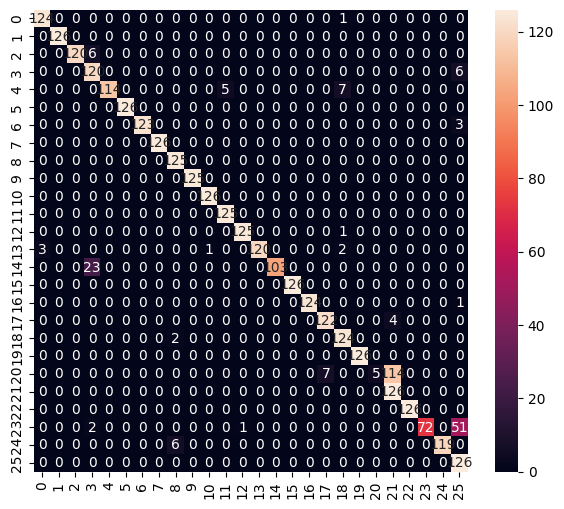

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       125
           1       1.00      1.00      1.00       126
           2       1.00      0.95      0.98       126
           3       0.79      0.95      0.87       126
           4       1.00      0.90      0.95       126
           5       1.00      1.00      1.00       126
           6       1.00      0.98      0.99       126
           7       1.00      1.00      1.00       126
           8       0.94      1.00      0.97       125
           9       1.00      1.00      1.00       125
          10       0.99      1.00      1.00       126
          11       0.96      1.00      0.98       125
          12       0.99      0.99      0.99       126
          13       1.00      0.95      0.98       126
          14       1.00      0.82      0.90       126
          15       1.00      1.00      1.00       126
          16       1.00      0.99      1.00       125
     

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [38]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [39]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Alfian\AppData\Local\Temp\tmpfsilhia7\assets


INFO:tensorflow:Assets written to: C:\Users\Alfian\AppData\Local\Temp\tmpfsilhia7\assets


164704

# Inference test

In [40]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [41]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [42]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [43]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 3.57 ms


In [44]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.5574529e-05 6.3236989e-09 4.8830376e-08 5.3025028e-03 1.1707144e-07
 1.1157938e-07 2.7137569e-03 2.1514257e-02 4.6191201e-07 4.6058008e-03
 1.1691061e-06 5.4413607e-07 1.2143861e-04 5.1135288e-05 7.6437573e-05
 4.0408548e-05 8.7589643e-07 4.8954835e-06 3.2211243e-05 9.6401203e-01
 5.1206410e-08 1.1887925e-10 6.3315195e-13 1.4911322e-03 2.7602022e-07
 1.4837925e-05]
19
